# **Importing Libraries**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=585c0ce3393deae2de1ea522f6f61104c1bbb834106632d5d05dcd36b1ed7725
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, exp

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("diabetes_modelling") \
    .config("spark.executer.memory", "16gb") \
    .getOrCreate()



sc = spark.sparkContext
sc

<SparkContext master=local appName=diabetes_modelling>

In [ ]:
spark_df=spark.read.csv("/content/sample_data/diabetes_prediction_dataset.csv",header=True,inferSchema=True,sep=",")
spark_df.cache()

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, smoking_history: string, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int]

In [ ]:
spark_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [ ]:
spark_df.show(5)

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
only showing top 5 rows



In [ ]:
spark_df.count()

100000

In [ ]:
len(spark_df.columns)

9

In [ ]:
spark_df.describe().show()

+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|  count|100000|           100000|            100000|            100000|         100000|           100000|            100000|             100000|             100000|
|   mean|  NULL|41.88585600000013|           0.07485|           0.03942|           NULL|27.32076709999422|5.5275069999983275|          138.05806|              0.085|
| stddev|  NULL|22.51683987161704|0.2631504702289171|0.1945930169980986|           NULL|6.636783416648357|1.0706720918835468|  40.70813604870383|0.27888308976661896|
|   

In [ ]:
spark_df.dropDuplicates().show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|21.0|           0|            0|          never|27.32|        5.8|                126|       0|
|  Male|26.0|           0|            0|          never|27.32|        6.6|                100|       0|
|Female|49.0|           0|            0|          never| 21.7|        5.8|                158|       0|
|Female|24.0|           0|            0|         former|20.47|        4.8|                100|       0|
|Female|53.0|           0|            0|          never| 31.4|        5.7|                 85|       0|
|Female|74.0|           0|            0|         former| 40.5|        3.5|                160|       0|
|  Male|76.0|           0|            0|         former|27.76|  

In [ ]:
spark_df.distinct().count()

96146

In [ ]:
spark_df.crosstab("age","blood_glucose_level").show()

+-----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|age_blood_glucose_level|100|126|130|140|145|155|158|159|160|200|220|240|260|280|300| 80| 85| 90|
+-----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|                    1.0| 11|  5|  6|  8|  3|  8|  4|  8|  2|  5|  0|  0|  0|  0|  0|  6| 11|  6|
|                   0.32|  5|  9|  8|  4|  8|  8|  4| 10|  7|  4|  0|  0|  0|  0|  0|  8|  6|  8|
|                   50.0| 92|110|119|123|128|102| 90|101|117|114|  7|  8| 14| 14| 13| 98| 93|112|
|                   75.0| 33| 53| 56| 50| 61| 44| 53| 61| 56| 59|  8| 13|  8| 21| 12| 42| 51| 40|
|                   22.0| 91| 94|102| 98| 99| 83|109| 96| 80| 81|  4|  4|  0|  2|  3| 99| 95| 97|
|                   65.0| 82| 87| 83| 98| 81| 74| 67| 86| 99| 78| 24| 14| 17| 28| 17| 52| 69| 78|
|                   38.0|109|114|126| 97|129|108|128|105| 86|109|  8|  5|  6|  5|  8|130|126| 99|
|                   

# **Outlier Detection**

In [ ]:
numericals=["age","bmi","HbA1c_level","blood_glucose_level"]
bounds={}

In [ ]:
for nc in numericals:

  quantiles = spark_df.approxQuantile(nc, [0.25,0.75], relativeError=0.05)
  IQR=quantiles[1]-quantiles[0]
  bounds[nc]=[
      quantiles[0]-1.5*IQR,
      quantiles[1]+1.5*IQR
  ]


In [ ]:
bounds

{'age': [-23.0, 105.0],
 'bmi': [16.765, 35.765],
 'HbA1c_level': [2.6999999999999993, 8.3],
 'blood_glucose_level': [13.0, 245.0]}

In [ ]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from functools import reduce
spark_df.select(
    *[col(c) for c in numericals],
    *[
        F.when(
           col(c).between(bounds[c][0], bounds[c][1]),
           0
        ).otherwise(1).alias(c+"_out")
        for c in numericals
    ]
).where(reduce(lambda x, y: x | y,  (col(c+"_out") == 1 for c in numericals))).toPandas()

,age,bmi,HbA1c_level,blood_glucose_level,age_out,bmi_out,HbA1c_level_out,blood_glucose_level_out
0,54.0,54.70,6.0,100,0,1,0,0
1,78.0,36.05,5.0,130,0,1,0,0
2,40.0,36.38,6.0,90,0,1,0,0
3,4.0,13.99,4.0,140,0,1,0,0
4,5.0,15.10,5.8,85,0,1,0,0
...,...,...,...,...,...,...,...,...
16625,61.0,34.45,6.5,280,0,0,0,1
16626,47.0,45.15,4.0,126,0,1,0,0
16627,58.0,38.31,7.0,200,0,1,0,0
16628,32.0,37.71,6.1,126,0,1,0,0


In [ ]:
spark_df.describe("blood_glucose_level").show()

+-------+-------------------+
|summary|blood_glucose_level|
+-------+-------------------+
|  count|             100000|
|   mean|          138.05806|
| stddev|  40.70813604870383|
|    min|                 80|
|    max|                300|
+-------+-------------------+



In [ ]:
spark_df.describe("age").show()

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|           100000|
|   mean|41.88585600000013|
| stddev|22.51683987161704|
|    min|             0.08|
|    max|             80.0|
+-------+-----------------+



In [ ]:
spark_df.describe("bmi").show()

+-------+-----------------+
|summary|              bmi|
+-------+-----------------+
|  count|           100000|
|   mean|27.32076709999422|
| stddev|6.636783416648357|
|    min|            10.01|
|    max|            95.69|
+-------+-----------------+



In [ ]:
spark_df.describe("HbA1c_level").show()

+-------+------------------+
|summary|       HbA1c_level|
+-------+------------------+
|  count|            100000|
|   mean|5.5275069999983275|
| stddev|1.0706720918835468|
|    min|               3.5|
|    max|               9.0|
+-------+------------------+



# **Outlier Visualization**

In [ ]:
df=spark_df.toPandas()

Text(0.5, 1.0, 'HbA1c_level Boxplot')

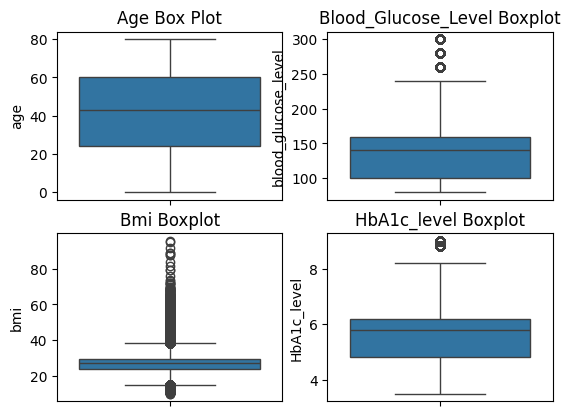

In [ ]:
plt.subplot(2,2,1)
sns.boxplot(df["age"])
plt.title("Age Box Plot")


plt.subplot(2,2,3)
sns.boxplot(df["bmi"])
plt.title("Bmi Boxplot")


plt.subplot(2,2,2)
sns.boxplot(df["blood_glucose_level"])
plt.title("Blood_Glucose_Level Boxplot")


plt.subplot(2,2,4)
sns.boxplot(df["HbA1c_level"])
plt.title("HbA1c_level Boxplot")

As it can be seen age doesn't have any outliers.Meanwhile, Bmi has the most one.

# **Age Feature Visualization**

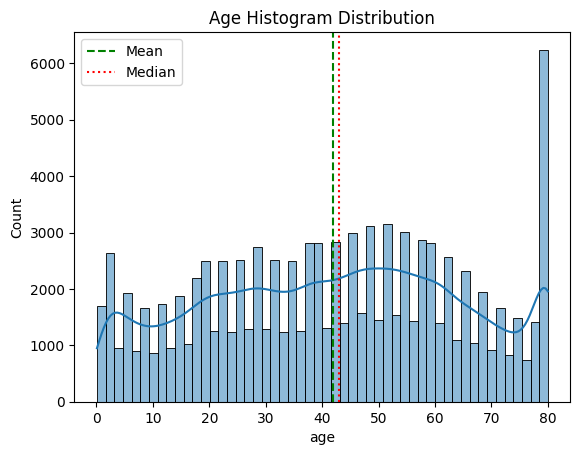

In [ ]:
sns.histplot(df["age"],kde=True)
plt.axvline(np.mean(df["age"]),ls="--",c="g",label="Mean")
plt.axvline(np.median(df["age"]),ls=":",c="r",label="Median")
plt.title("Age Histogram Distribution");
plt.legend()

Age feature has a balanced distribution which is close to normal distribution since mean and median values are close to each other.

Since old ages may increase some health problems, it is better to examine age feature by seperating some intervals such as kids,young adults,middle age adults and senior adults

In [ ]:
df["age_cut"]=pd.cut(x=df["age"],bins=[df["age"].min()-1,18,30,60,df["age"].max()],labels=["kids","young_adults","middle_age_adults","senior_adults"])

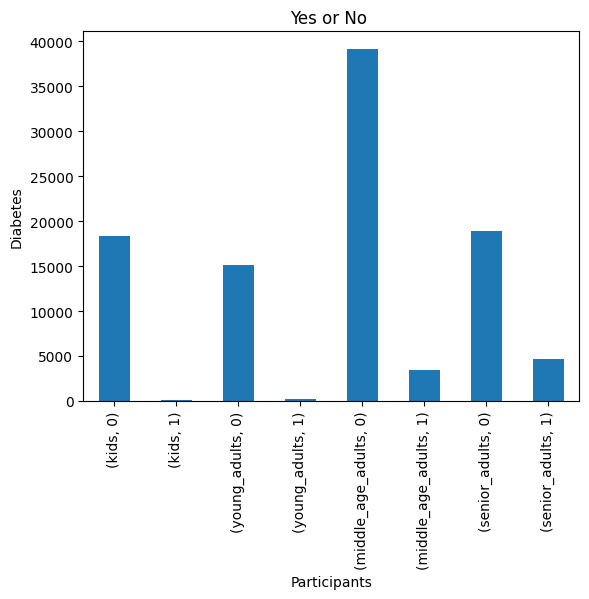

In [ ]:
df.groupby(df["age_cut"])["diabetes"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

As it was guessed,age is a huge factor. Especially for kids and young adults, diabetes risk is significantly low but for seniors,the risk can not be ignored.

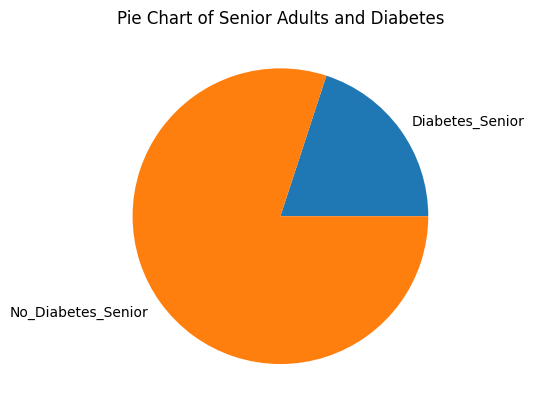

In [ ]:
Diabetes_Senior= ((df['age_cut'] == 'senior_adults') & (df['diabetes'] == 1)).value_counts().get(True, 0)
No_Diabetes_Senior = ((df['age_cut'] == 'senior_adults') & (df['diabetes'] == 0)).value_counts().get(True, 0)

numbers = [Diabetes_Senior,No_Diabetes_Senior ]
labels = ['Diabetes_Senior', 'No_Diabetes_Senior']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Senior Adults and Diabetes")

plt.show()

Pie chart indicates that approximately %20 of senior in our dataset has diabetes.

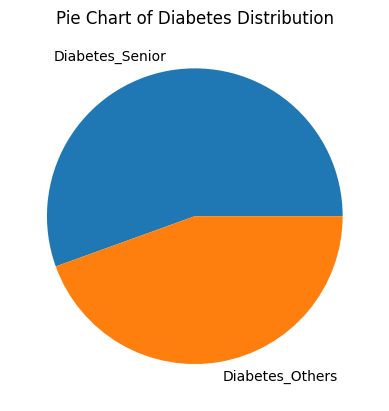

In [ ]:
Diabetes_Senior= ((df['age_cut'] == 'senior_adults') & (df['diabetes'] == 1)).value_counts().get(True, 0)
Diabetes_Others = ((df['age_cut'] != 'senior_adults') & (df['diabetes'] == 1)).value_counts().get(True, 0)

numbers = [Diabetes_Senior,Diabetes_Others]
labels = ['Diabetes_Senior', 'Diabetes_Others']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Diabetes Distribution")

plt.show()

In [ ]:
df[df["age"].between(50,60)]["diabetes"].value_counts()

diabetes
0    14214
1     2072
Name: count, dtype: int64

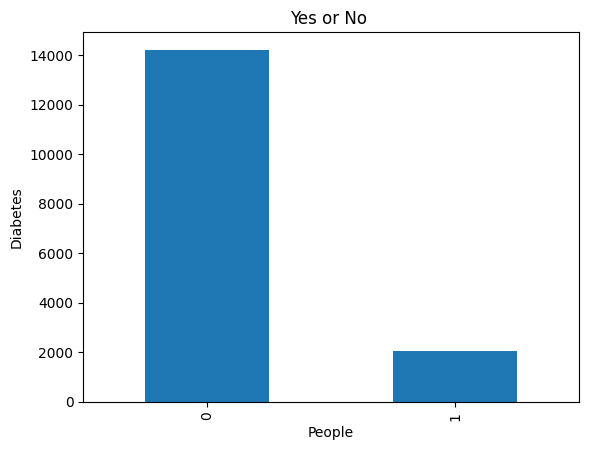

In [ ]:
df[df["age"].between(50,60)]["diabetes"].value_counts().plot(kind="bar")
plt.xlabel('People')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

In [ ]:
df.groupby("age_cut")["diabetes"].value_counts()

age_cut            diabetes
kids               0           18308
                   1              92
young_adults       0           15124
                   1             209
middle_age_adults  0           39155
                   1            3480
senior_adults      0           18913
                   1            4719
Name: count, dtype: int64

<Axes: xlabel='diabetes'>

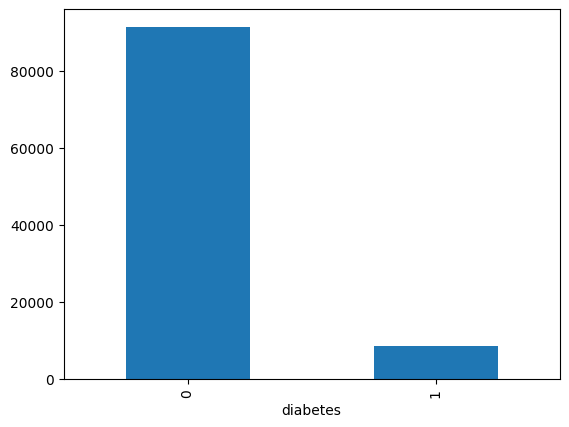

In [ ]:
df["diabetes"].value_counts().plot(kind="bar")

In [ ]:
df["diabetes"].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

From the barplot and number comparison in different age intervals, it is clear that 50+ years old people have significantly higher risk and those people are responsible for %80 of cases.

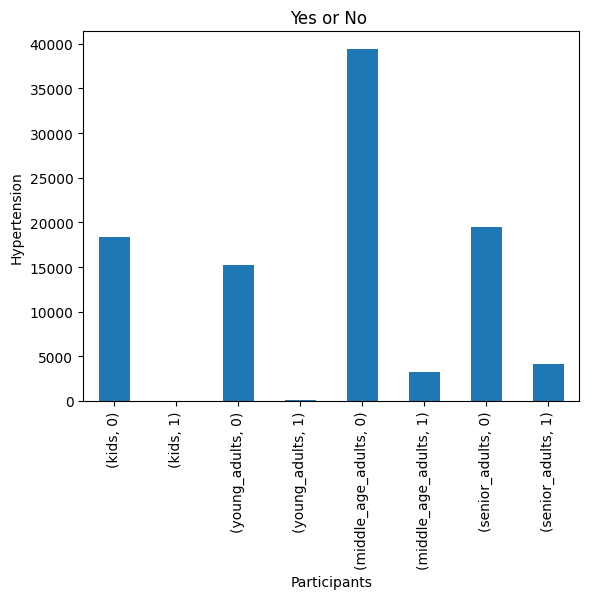

In [ ]:
df.groupby(df["age_cut"])["hypertension"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Hypertension')
plt.title('Yes or No ')
plt.show()

In [ ]:
for i in df["age_cut"].unique():

  print(i,df[df["age_cut"]==i]["hypertension"].value_counts()[1]/(df[df["age_cut"]==i]["hypertension"].value_counts()[0]+df[df["age_cut"]==i]["hypertension"].value_counts()[1]))

senior_adults 0.1752708192281652
middle_age_adults 0.07526679957781165
young_adults 0.008087132328963673
kids 0.0005434782608695652


Senior_Adults more likely to have hypertension and as it can be seen, when age increases, the possibilty to have hypertension is also increasing

In [ ]:
for i in df["age_cut"].unique():

  print(i,df[df["age_cut"]==i]["heart_disease"].value_counts()[1]/(df[df["age_cut"]==i]["heart_disease"].value_counts()[0]+df[df["age_cut"]==i]["heart_disease"].value_counts()[1]))

senior_adults 0.12402674339878131
middle_age_adults 0.023361088307728393
young_adults 0.0006521880910454575
kids 0.0002717391304347826


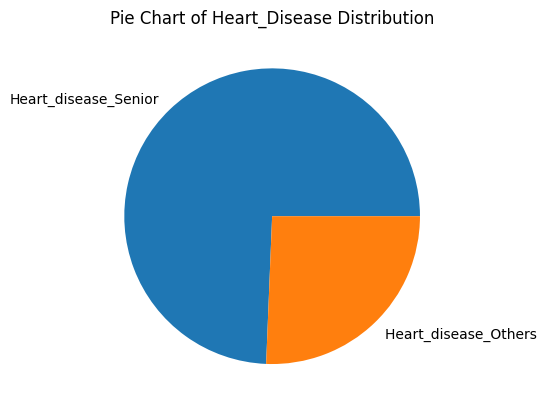

In [ ]:
Heart_disease_Senior= ((df['age_cut'] == 'senior_adults') & (df['heart_disease'] == 1)).value_counts().get(True, 0)
Heart_disease_Others = ((df['age_cut'] != 'senior_adults') & (df['heart_disease'] == 1)).value_counts().get(True, 0)

numbers = [Heart_disease_Senior,Heart_disease_Others ]
labels = ['Heart_disease_Senior', 'Heart_disease_Others ']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Heart_Disease Distribution")

plt.show()

Heart_Diseases are also mostly in seniors. The possibility to exist increases with age.

# **BMI Feature Visualization**

Since it is known that the people who has over 30 bmi is obese and has opportunity to have more health problems

In [ ]:
df[df["bmi"]>30]["diabetes"].value_counts()

diabetes
0    19251
1     4232
Name: count, dtype: int64

In [ ]:
df[df["bmi"]<30]["diabetes"].value_counts()

diabetes
0    72197
1     4267
Name: count, dtype: int64

As it can be seen bmi is an important factor for diabetes

In [ ]:
df["bmi_cut"]=pd.cut(x=df["bmi"],bins=[df["bmi"].min()-1,18.5,25,30,df["bmi"].max()],labels=["under_weight","normal_weight","overweight","obese"])

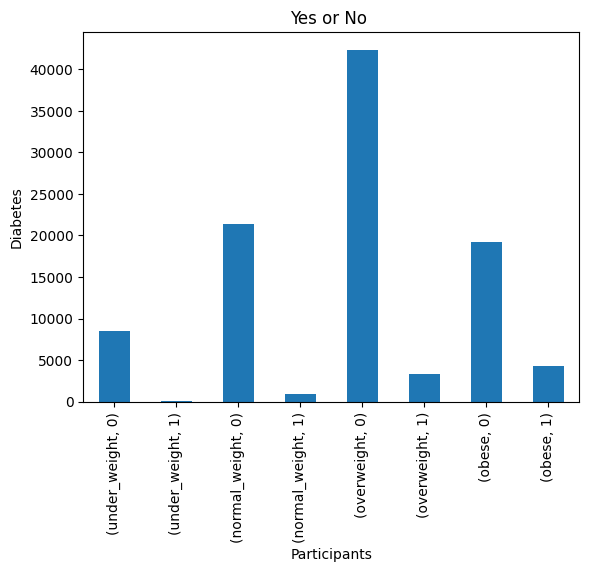

In [ ]:
df.groupby(df["bmi_cut"])["diabetes"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

In [ ]:
for i in df["bmi_cut"].unique():

  print(i,df[df["bmi_cut"]==i]["diabetes"].value_counts()[1]/(df[df["bmi_cut"]==i]["diabetes"].value_counts()[0]+df[df["bmi_cut"]==i]["diabetes"].value_counts()[1]))

overweight 0.07301170550268023
normal_weight 0.03889462114754834
obese 0.1802154750244858
under_weight 0.0075108555333881


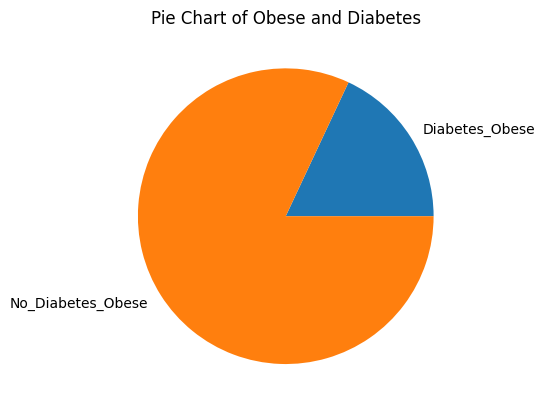

In [ ]:
Diabetes_Obese= ((df['bmi_cut'] == 'obese') & (df['diabetes'] == 1)).value_counts().get(True, 0)
No_Diabetes_Obese = ((df['bmi_cut'] == 'obese') & (df['diabetes'] == 0)).value_counts().get(True, 0)

numbers = [Diabetes_Obese,No_Diabetes_Obese ]
labels = ['Diabetes_Obese', 'No_Diabetes_Obese']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Obese and Diabetes")

plt.show()

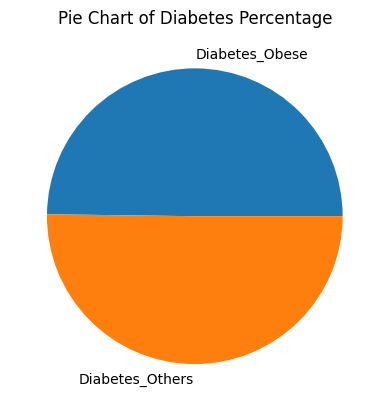

In [ ]:
Diabetes_Obese= ((df['bmi_cut'] == 'obese') & (df['diabetes'] == 1)).value_counts().get(True, 0)
Diabetes_Others = ((df['bmi_cut'] != 'obese') & (df['diabetes'] == 1)).value_counts().get(True, 0)

numbers = [Diabetes_Obese,Diabetes_Others ]
labels = ['Diabetes_Obese', 'Diabetes_Others']
plt.pie(numbers, labels=labels)
plt.title("Pie Chart of Diabetes Percentage")

plt.show()

Obese people are account for nearly %50 of diabetes cases

In [ ]:
for i in df["bmi_cut"].unique():

  print(i,df[df["bmi_cut"]==i]["hypertension"].value_counts()[1]/(df[df["bmi_cut"]==i]["hypertension"].value_counts()[0]+df[df["bmi_cut"]==i]["hypertension"].value_counts()[1]))

overweight 0.06966415053057652
normal_weight 0.04517518280920551
obese 0.13792956606907125
under_weight 0.006454641474005399


Although there is no significant difference between normal weight and overweight people who has hypertension, obese people have significantly higher possibility to have it.

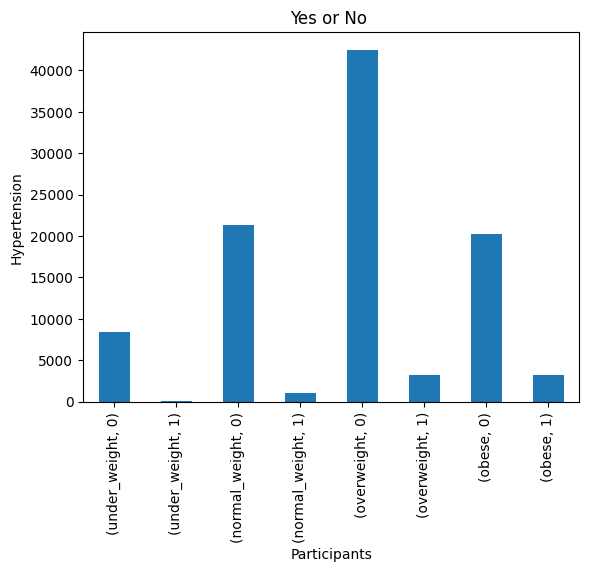

In [ ]:
df.groupby(df["bmi_cut"])["hypertension"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Hypertension')
plt.title('Yes or No ')
plt.show()

In [ ]:
for i in df["bmi_cut"].unique():

  print(i,df[df["bmi_cut"]==i]["heart_disease"].value_counts()[1]/(df[df["bmi_cut"]==i]["heart_disease"].value_counts()[0]+df[df["bmi_cut"]==i]["heart_disease"].value_counts()[1]))

overweight 0.04161470298654414
normal_weight 0.029384056345610338
obese 0.05697738789762807
under_weight 0.005515784532331886


Obese people has highest percentage to have a heart disease but the difference between other groups are less except under weight people

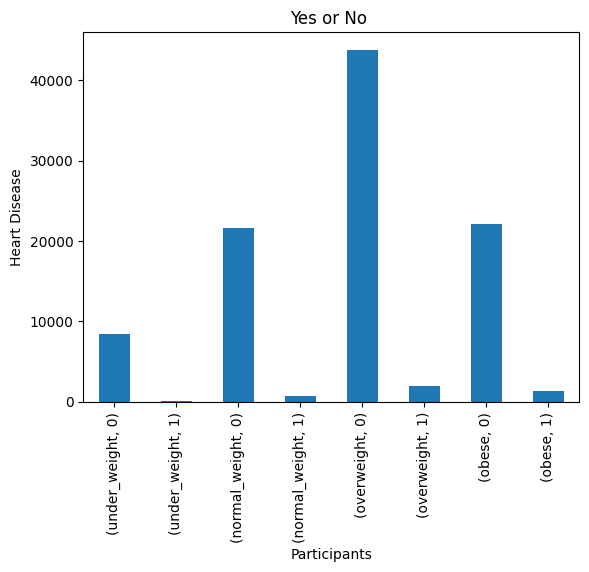

In [ ]:
df.groupby(df["bmi_cut"])["heart_disease"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Heart Disease')
plt.title('Yes or No ')
plt.show()

# **Hypertension and Heart_Disease Relationship**

In [ ]:
for i in df["heart_disease"].unique():

  print(i,df[df["heart_disease"]==i]["hypertension"].value_counts()[1]/(df[df["heart_disease"]==i]["hypertension"].value_counts()[0]+df[df["heart_disease"]==i]["hypertension"].value_counts()[1]))

1 0.23236935565702688
0 0.06838576693247829


It can be seen that people who has a heart disease have more possibilty to have hypertension.

# **Correlation Check**

# **Numerical** **Correlation**

In [ ]:
numerics=["age","bmi","blood_glucose_level","HbA1c_level"]

<Axes: >

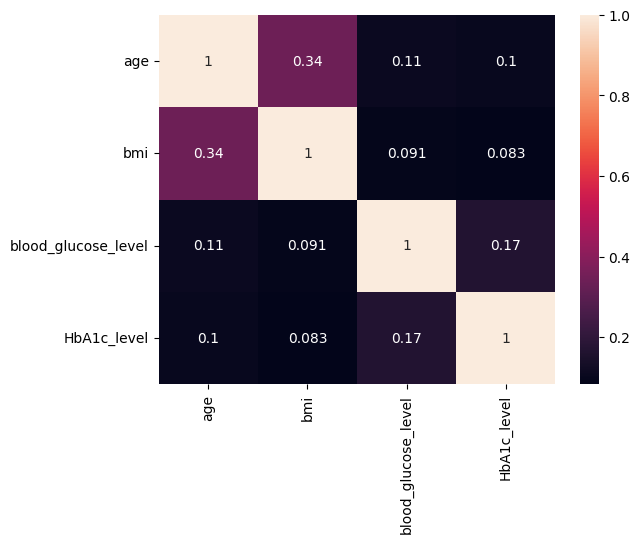

In [ ]:
sns.heatmap(data=df[list(numerics)].corr(),annot=True)

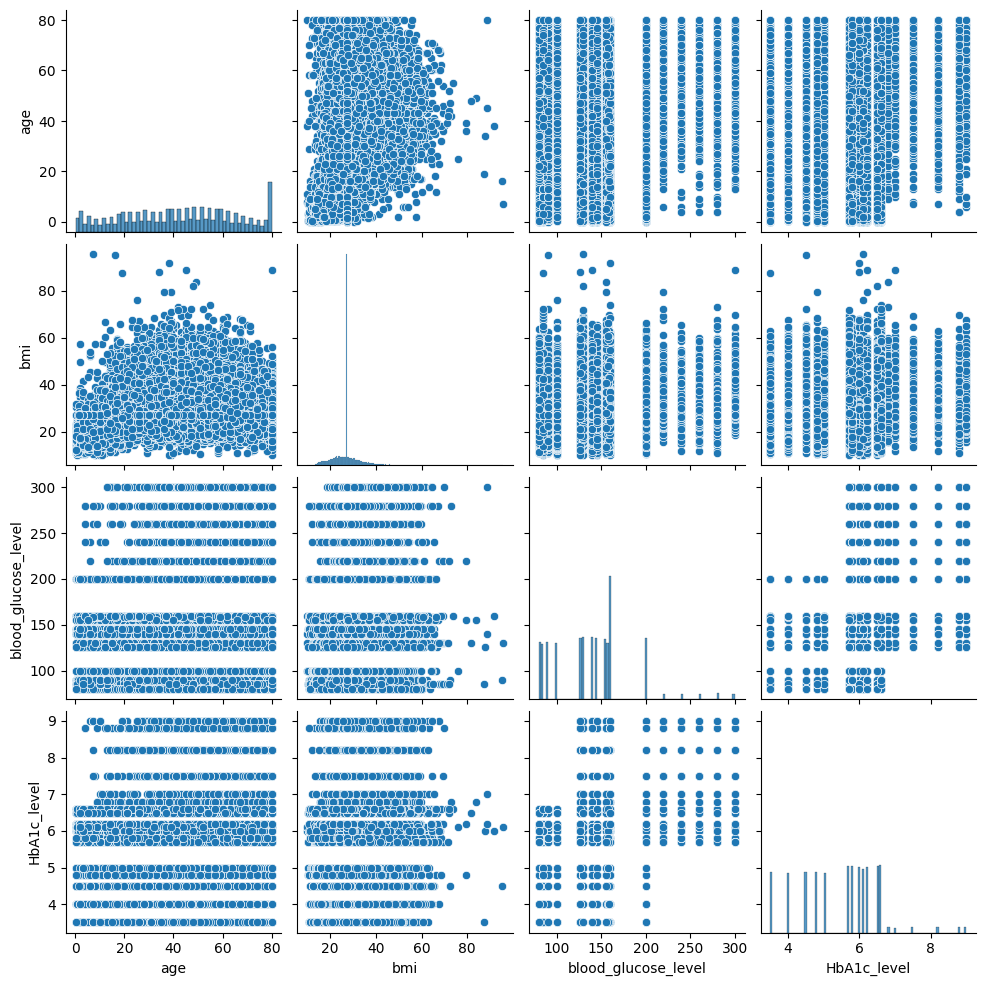

In [ ]:
sns.pairplot(df[list(numerics)])

<Axes: xlabel='age', ylabel='bmi'>

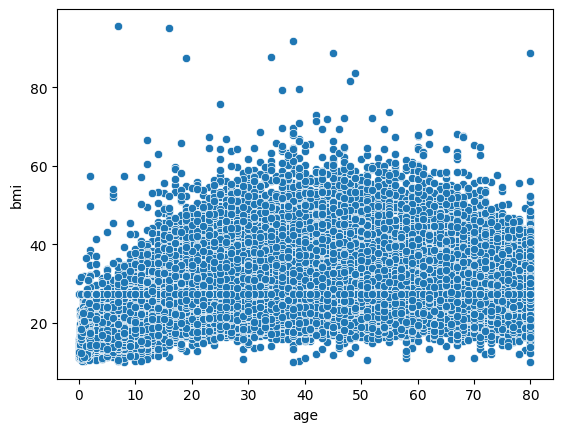

In [ ]:
sns.scatterplot(data=df[list(numerics)],x="age",y="bmi")

There is no strong correlation between numerical values

# **Categorical Correlations**

As our previous analysis it was found that some age and bmi groups have a correlation between other categorical datas. Moreover, hypertension and heart_disease features have correlation. Now it will be checked that those correlations are strong or not. If they are strong, some feature engineerings may be needed. Age_cut and Bmi_cut features which we created are ordinal categorical,other ones are nominal categorical features.

# **Ordinal Categorical Feature Correlation Check**

To measure the degree of correlation between nominal datas and ordinal datas, spearman correlation test can be used.

In [ ]:
from scipy import stats

In [ ]:
df["hypertension"]=df["hypertension"].replace([1,0],["exist","non-exist"])
df["heart_disease"]=df["heart_disease"].replace([1,0],["exist","non-exist"])

In [ ]:
nominals=["smoking_history","hypertension","heart_disease"]

# **Age Intervals Correlation**

In [ ]:
for y in nominals:

  x=df["age_cut"]

  res = stats.spearmanr(x, df[y])
  print(res.statistic)

0.20243922198706918
-0.09229451272372852
-0.10690516569064071


As it was found before,there is a correlation but this correlation is so weak.

# **BMI Intervals Correlations**

In [ ]:
for y in nominals:

  x=df["bmi_cut"]

  res = stats.spearmanr(x, df[y])
  print(res.statistic)

-0.18643402407656964
0.040730119679567925
0.017529834842542506


Also Bmi intervals don't have strong correlation with other nominal categorical features.

# **Nominal Categorical Feature Correlation Check**

To check nominal categorical data correlation and to find its strength Chisquare test based Cramer V coefficent can be used.

In [ ]:
from scipy.stats import chi2_contingency
import itertools
combinations = list(itertools.combinations(nominals, 2))
print(combinations)

[('smoking_history', 'hypertension'), ('smoking_history', 'heart_disease'), ('hypertension', 'heart_disease')]


In [ ]:
for i,j in combinations:
  crosstab=pd.crosstab(df[i],df[j])
  X2=(chi2_contingency(crosstab))[0]
  N = np.sum(crosstab).sum()
  minimum_dimension = min(crosstab.shape)-1

# Calculate Cramer's V
  result = np.sqrt((X2/N) / minimum_dimension)

# Print the result
  print(i,j,result)

smoking_history hypertension 0.1315269564242348
smoking_history heart_disease 0.11087440878630854
hypertension heart_disease 0.12116401057785126


As it can be seen, there are correlations between nominal features. However those correlations are weak.

Correlation analysis strongly recommend that dataset doesn't need a feature drop our feature creation.

# **Outlier Handling**

In [69]:
spark_df=spark_df.select(
    *[col(c) for c in spark_df.columns],
    *[
        F.when(
           col(c)<bounds[c][0],
           bounds[c][0]
        ).when(col(c)>bounds[c][1],
           bounds[c][1]). otherwise(col(c)).alias(c+"_new")
        for c in numericals])

In [70]:
spark_df.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+-------+-------+---------------+-----------------------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|age_new|bmi_new|HbA1c_level_new|blood_glucose_level_new|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+-------+-------+---------------+-----------------------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|   80.0|  25.19|            6.6|                  140.0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|   54.0|  27.32|            6.6|                   80.0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|   28.0|  27.32|            5.7|                  158.0|
|Female|36.0|           0|            0|

Since we created columns that don't have outlier values,we don't need previous ones.

In [71]:
spark_df_new=spark_df.drop("blood_glucose_level","HbA1c_level","age","bmi")

In [72]:
spark_df_new.show()

+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+
|gender|hypertension|heart_disease|smoking_history|diabetes|age_new|bmi_new|HbA1c_level_new|blood_glucose_level_new|
+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+
|Female|           0|            1|          never|       0|   80.0|  25.19|            6.6|                  140.0|
|Female|           0|            0|        No Info|       0|   54.0|  27.32|            6.6|                   80.0|
|  Male|           0|            0|          never|       0|   28.0|  27.32|            5.7|                  158.0|
|Female|           0|            0|        current|       0|   36.0|  23.45|            5.0|                  155.0|
|  Male|           1|            1|        current|       0|   76.0|  20.14|            4.8|                  155.0|
|Female|           0|            0|          never|       0|   2

In [73]:
df_new=spark_df_new.toPandas()

# **Boxplot after Outlier Handling**

Text(0.5, 1.0, 'Bmi Boxplot')

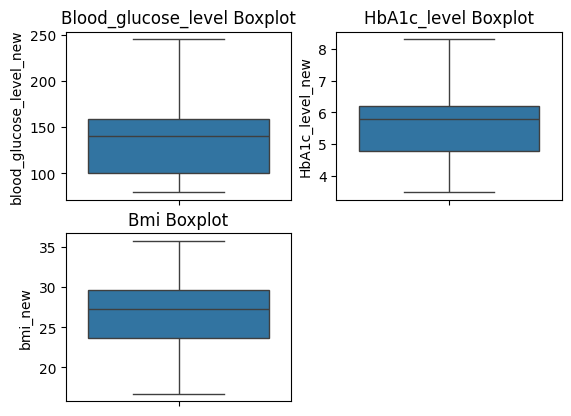

In [74]:

plt.subplot(2,2,1)
sns.boxplot(df_new["blood_glucose_level_new"])
plt.title("Blood_glucose_level Boxplot")



plt.subplot(2,2,2)
sns.boxplot(df_new["HbA1c_level_new"])
plt.title("HbA1c_level Boxplot")



plt.subplot(2,2,3)
sns.boxplot(df_new["bmi_new"])
plt.title("Bmi Boxplot")

As it can be seen, outlier treatment worked

# **Missing Value Control**


In [75]:
for col in spark_df_new.columns:
  print(col,":",spark_df_new.filter(spark_df_new[col].isNull()).count())

gender : 0
hypertension : 0
heart_disease : 0
smoking_history : 0
diabetes : 0
age_new : 0
bmi_new : 0
HbA1c_level_new : 0
blood_glucose_level_new : 0


In [76]:
new_numericals=[]
for i in numericals:
  new_numericals.append(i+"_new")

In [77]:
new_numericals

['age_new', 'bmi_new', 'HbA1c_level_new', 'blood_glucose_level_new']

# **Working on Another Features**

<Axes: xlabel='smoking_history'>

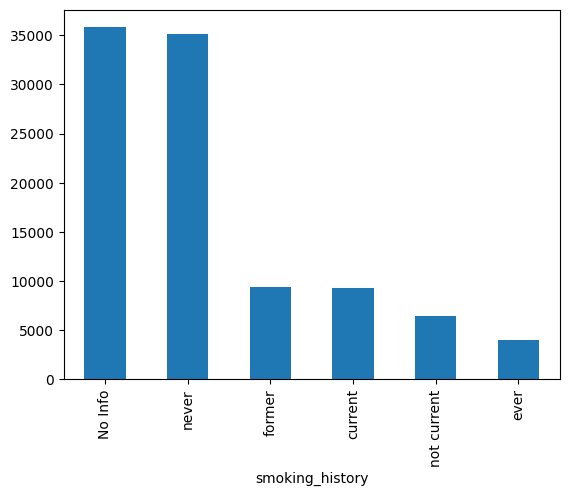

In [79]:
df_new["smoking_history"].value_counts().plot(kind='bar')

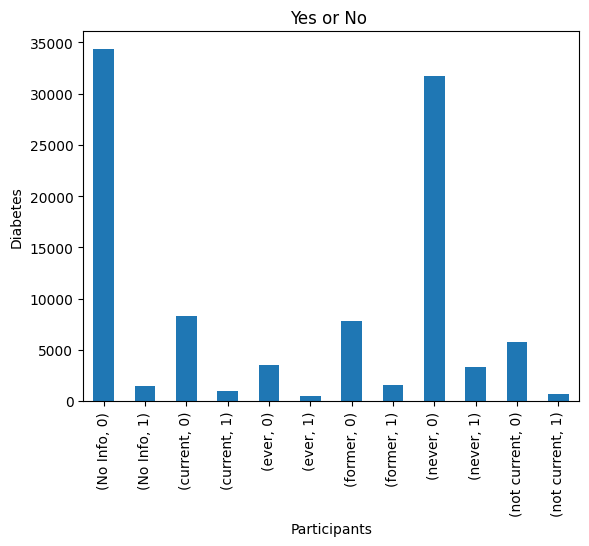

In [80]:
df_new.groupby("smoking_history")["diabetes"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Diabetes')
plt.title('Yes or No ')
plt.show()

In [81]:
df["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

Smoking_History feature has No Info type variable.To find which variable is best to replace that variable, it is better to look its relationship with dependent one. From previous correlation tests with Spearman coefficient(Ordinals) and Cramer V coefficent(Nomimals), it was stated as smoking_feature hasn't got a strong correlation with other features but it is also better to show it seperately again.

In [82]:
df_new[df_new["smoking_history"]=="No Info"]["diabetes"].value_counts()

diabetes
0    34362
1     1454
Name: count, dtype: int64

In [83]:
df_new["smoking_history"].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [84]:
for i in df["smoking_history"].unique():

  print(i,df[df["smoking_history"]==i]["diabetes"].value_counts()[1]/(df[df["smoking_history"]==i]["diabetes"].value_counts()[0]+df[df["smoking_history"]==i]["diabetes"].value_counts()[1]))

never 0.09534121669753526
No Info 0.040596381505472415
current 0.10208916648718501
former 0.17001710863986313
ever 0.11788211788211789
not current 0.10702652396463472


As it can be clearly seen, there is no significant difference between variables about relationship with dependent variable

In [85]:
for i in df_new["smoking_history"].unique():
  print(i,df_new[df_new["smoking_history"]==i]["hypertension"].value_counts()[1]/(df_new[df_new["smoking_history"]==i]["hypertension"].value_counts()[0]+df_new[df_new["smoking_history"]==i]["hypertension"].value_counts()[1]))


never 0.09129505627582277
No Info 0.03356041992405629
current 0.08959724316174887
former 0.14317792985457656
ever 0.10464535464535464
not current 0.07584923220102373


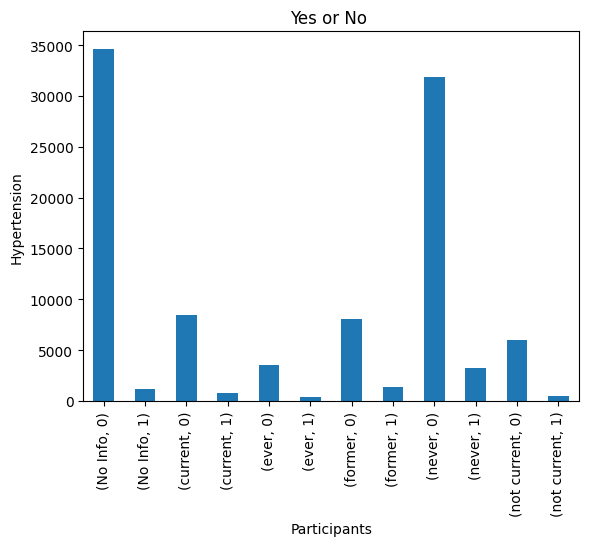

In [86]:
df_new.groupby("smoking_history")["hypertension"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Hypertension')
plt.title('Yes or No ')
plt.show()

In [87]:
for i in df_new["smoking_history"].unique():
  print(i,df_new[df_new["smoking_history"]==i]["heart_disease"].value_counts()[1]/(df_new[df_new["smoking_history"]==i]["heart_disease"].value_counts()[0]+df_new[df_new["smoking_history"]==i]["heart_disease"].value_counts()[1]))

never 0.031258013962102864
No Info 0.02577060531605986
current 0.04404479862158087
former 0.09709153122326775
ever 0.07817182817182818
not current 0.04529238405459904


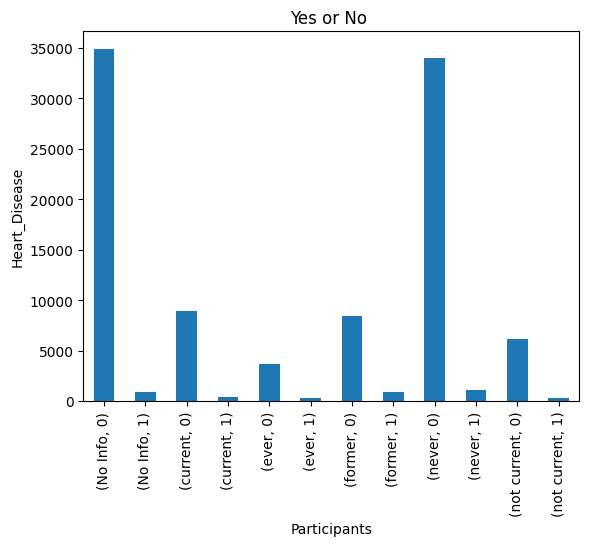

In [88]:
df_new.groupby("smoking_history")["heart_disease"].value_counts().plot(kind='bar')
plt.xlabel('Participants')
plt.ylabel('Heart_Disease')
plt.title('Yes or No ')
plt.show()

After looking its relationship with other categorical independent variables seperately , it can be stated again that there is no strong relationship between smoking_history feature and them. Since dataset already have so much datas and there is no strong correlation, droping the No Info rows are best choice.

In [89]:
spark_df_new=spark_df_new.where(spark_df_new.smoking_history!="No Info")

In [90]:
spark_df_new.show()

+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+
|gender|hypertension|heart_disease|smoking_history|diabetes|age_new|bmi_new|HbA1c_level_new|blood_glucose_level_new|
+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+
|Female|           0|            1|          never|       0|   80.0|  25.19|            6.6|                  140.0|
|  Male|           0|            0|          never|       0|   28.0|  27.32|            5.7|                  158.0|
|Female|           0|            0|        current|       0|   36.0|  23.45|            5.0|                  155.0|
|  Male|           1|            1|        current|       0|   76.0|  20.14|            4.8|                  155.0|
|Female|           0|            0|          never|       0|   20.0|  27.32|            6.6|                   85.0|
|Female|           0|            0|          never|       1|   4

In [91]:
spark_df_new.select("smoking_history").distinct().count()

5

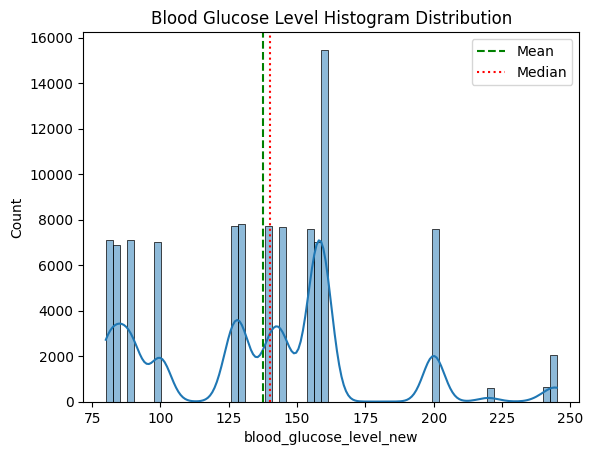

In [92]:
sns.histplot(df_new["blood_glucose_level_new"],kde=True)
plt.axvline(np.mean(df_new["blood_glucose_level_new"]),ls="--",c="g",label="Mean")
plt.axvline(np.median(df_new["blood_glucose_level_new"]),ls=":",c="r",label="Median")
plt.title("Blood Glucose Level Histogram Distribution");
plt.legend()

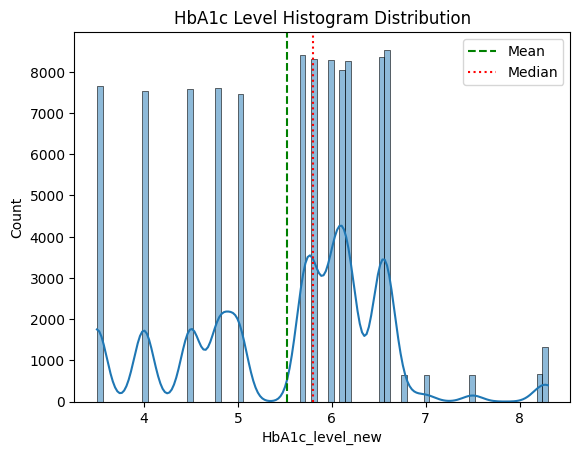

In [93]:
sns.histplot(df_new["HbA1c_level_new"],kde=True)
plt.axvline(np.mean(df_new["HbA1c_level_new"]),ls="--",c="g",label="Mean")
plt.axvline(np.median(df_new["HbA1c_level_new"]),ls=":",c="r",label="Median")
plt.title("HbA1c Level Histogram Distribution");
plt.legend()

# **StringIndex**

In [94]:
from pyspark.ml.feature import StringIndexer
stringIndexer=StringIndexer(inputCol="diabetes",outputCol="label")
spark_df_ind=stringIndexer.fit(spark_df_new).transform(spark_df_new)

In [95]:
spark_df_ind.dtypes

[('gender', 'string'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('smoking_history', 'string'),
 ('diabetes', 'int'),
 ('age_new', 'double'),
 ('bmi_new', 'double'),
 ('HbA1c_level_new', 'double'),
 ('blood_glucose_level_new', 'double'),
 ('label', 'double')]

In [96]:
spark_df_ind=spark_df_ind.withColumn("label",spark_df_ind["label"].cast("integer"))

In [97]:
spark_df_ind.dtypes

[('gender', 'string'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('smoking_history', 'string'),
 ('diabetes', 'int'),
 ('age_new', 'double'),
 ('bmi_new', 'double'),
 ('HbA1c_level_new', 'double'),
 ('blood_glucose_level_new', 'double'),
 ('label', 'int')]

In [98]:
spark_df_ind.show()

+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+-----+
|gender|hypertension|heart_disease|smoking_history|diabetes|age_new|bmi_new|HbA1c_level_new|blood_glucose_level_new|label|
+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+-----+
|Female|           0|            1|          never|       0|   80.0|  25.19|            6.6|                  140.0|    0|
|  Male|           0|            0|          never|       0|   28.0|  27.32|            5.7|                  158.0|    0|
|Female|           0|            0|        current|       0|   36.0|  23.45|            5.0|                  155.0|    0|
|  Male|           1|            1|        current|       0|   76.0|  20.14|            4.8|                  155.0|    0|
|Female|           0|            0|          never|       0|   20.0|  27.32|            6.6|                   85.0|    0|
|Female|        

In [99]:
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(spark_df_ind) for column in list(set(spark_df_ind.columns)-set(new_numericals)-set(["label"]))]


pipeline = Pipeline(stages=indexers)
spark_df_ind = pipeline.fit(spark_df_ind).transform(spark_df_ind)

spark_df_ind.show()

+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+-----+------------+--------------+-------------------+------------------+---------------------+
|gender|hypertension|heart_disease|smoking_history|diabetes|age_new|bmi_new|HbA1c_level_new|blood_glucose_level_new|label|gender_index|diabetes_index|heart_disease_index|hypertension_index|smoking_history_index|
+------+------------+-------------+---------------+--------+-------+-------+---------------+-----------------------+-----+------------+--------------+-------------------+------------------+---------------------+
|Female|           0|            1|          never|       0|   80.0|  25.19|            6.6|                  140.0|    0|         0.0|           0.0|                1.0|               0.0|                  0.0|
|  Male|           0|            0|          never|       0|   28.0|  27.32|            5.7|                  158.0|    0|         1.0|           0.0|  

In [100]:
non_numericals=list(set(spark_df_new.columns)-set(new_numericals))

In [101]:
non_numericals

['gender', 'diabetes', 'heart_disease', 'hypertension', 'smoking_history']

In [102]:
spark_df_ind=spark_df_ind.drop('smoking_history',
 'diabetes',
 'hypertension',
 'heart_disease',
 'gender','diabetes','diabetes_index')

In [103]:
spark_df_ind.show()

+-------+-------+---------------+-----------------------+-----+------------+-------------------+------------------+---------------------+
|age_new|bmi_new|HbA1c_level_new|blood_glucose_level_new|label|gender_index|heart_disease_index|hypertension_index|smoking_history_index|
+-------+-------+---------------+-----------------------+-----+------------+-------------------+------------------+---------------------+
|   80.0|  25.19|            6.6|                  140.0|    0|         0.0|                1.0|               0.0|                  0.0|
|   28.0|  27.32|            5.7|                  158.0|    0|         1.0|                0.0|               0.0|                  0.0|
|   36.0|  23.45|            5.0|                  155.0|    0|         0.0|                0.0|               0.0|                  2.0|
|   76.0|  20.14|            4.8|                  155.0|    0|         1.0|                1.0|               1.0|                  2.0|
|   20.0|  27.32|            6.6| 

# **Vectorization**

In [104]:
from pyspark.ml.feature import VectorAssembler

In [105]:
vectorAssembler=VectorAssembler(inputCols=list(set(spark_df_ind.columns)-set(["label"])),outputCol="features")

In [106]:
va_df=vectorAssembler.transform(spark_df_ind)

In [107]:
final_df=va_df.select(["features","label"])

In [108]:
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[140.0,1.0,0.0,0....|    0|
|[158.0,0.0,0.0,0....|    0|
|[155.0,0.0,0.0,2....|    0|
|[155.0,1.0,1.0,2....|    0|
|(8,[0,4,5,6],[85....|    0|
|(8,[0,4,5,6],[200...|    1|
|[145.0,0.0,0.0,0....|    0|
|(8,[0,4,5,6],[100...|    0|
|(8,[0,4,5,6],[85....|    0|
|[100.0,0.0,0.0,1....|    0|
|[130.0,0.0,0.0,1....|    0|
|(8,[0,4,5,6],[200...|    0|
|[200.0,0.0,0.0,0....|    0|
|(8,[0,4,5,6],[158...|    0|
|[159.0,0.0,0.0,4....|    0|
|[90.0,0.0,0.0,2.0...|    0|
|(8,[0,4,5,6],[85....|    0|
|[130.0,1.0,0.0,1....|    0|
|[126.0,0.0,0.0,0....|    0|
|[200.0,1.0,0.0,3....|    1|
+--------------------+-----+
only showing top 20 rows



# **Train-Test Split**

In [109]:
splits=final_df.randomSplit([0.7,0.3])
train_df=splits[0]
test_df=splits[1]

# **Model Training**

In [110]:
from pyspark.ml.classification import GBTClassifier

In [111]:
gbm=GBTClassifier(maxIter=10,featuresCol="features",labelCol="label")

In [112]:
gbm_model=gbm.fit(train_df)

In [113]:
y_pred=gbm_model.transform(test_df)

In [114]:
ac=y_pred.select("label","prediction")

In [115]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

0.9640254060807997

# **HyperParameter Optimization**

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator= gbm, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds= 10)

In [ ]:
v_model = cv.fit(train_df)

In [ ]:
y_pred = v_model.transform(test_df)
ac = y_pred.select("label","prediction")

In [ ]:
evaluator.evaluate(y_pred)

0.9732542850868448